# Example-50: Advance (Phase advance sensitivity)

In [1]:
# In this example effect of systematic quadruple errors on phase advances is illustrated

In [2]:
# Import

from random import random
from pprint import pprint

import torch
from torch import Tensor

from pathlib import Path

import matplotlib
from matplotlib import pyplot as plt
matplotlib.rcParams['text.usetex'] = True

from model.library.line import Line

from model.command.external import load_sdds
from model.command.external import load_lattice
from model.command.build import build
from model.command.tune import tune
from model.command.advance import advance

In [3]:
# Load ELEGANT twiss

path = Path('ic.twiss')
parameters, columns = load_sdds(path)

nu_qx:Tensor = torch.tensor(parameters['nux'] % 1, dtype=torch.float64)
nu_qy:Tensor = torch.tensor(parameters['nuy'] % 1, dtype=torch.float64)

In [4]:
# Build and setup lattice

# Note, sextupoles are turned off and dipoles are linear 

# Load ELEGANT table

path = Path('ic.lte')
data = load_lattice(path)

# Build ELEGANT table

ring:Line = build('RING', 'ELEGANT', data)
ring.flatten()

# Merge drifts

ring.merge()

# Split BPMs

ring.split((None, ['BPM'], None, None))

# Roll lattice start

ring.roll(1)

# Set linear dipoles

for element in ring:
    if element.__class__.__name__ == 'Dipole':
        element.linear = True

# Split lattice into lines by BPMs

ring.splice()

# Set number of elements of different kinds

nb = ring.describe['BPM']
nq = ring.describe['Quadrupole']
ns = ring.describe['Sextupole']

In [5]:
# Compute tunes (fractional part)

guess = torch.tensor(4*[0.0], dtype=torch.float64)
nuqx, nuqy = tune(ring, [], alignment=False, matched=True, guess=guess, limit=8, epsilon=1.0E-9)

# Compare with elegant

print(torch.allclose(nu_qx, nuqx))
print(torch.allclose(nu_qy, nuqy))

True
True


In [6]:
# Compute nominal phase advances between BPMs

kn = torch.zeros(nq, dtype=torch.float64)

muqx_model, muqy_model = advance(ring, [kn], ('kn', ['Quadrupole'], None, None), matched=True, limit=1, epsilon=None).T

print(muqx_model.shape)
print(muqy_model.shape)

torch.Size([16])
torch.Size([16])


In [7]:
# Compute phase advances between BPMs using MC

kns = 0.01*torch.randn((8192, nq), dtype=torch.float64)

muqxs, muqys = torch.vmap(lambda kn: advance(ring, [kn], ('kn', ['Quadrupole'], None, None), matched=True, limit=1, epsilon=None), chunk_size=1024)(kns).swapaxes(0, -1)

dmuqxs = muqxs - muqx_model.unsqueeze(1)
dmuqys = muqys - muqy_model.unsqueeze(1)

print(dmuqxs.shape)
print(dmuqys.shape)

torch.Size([16, 8192])
torch.Size([16, 8192])


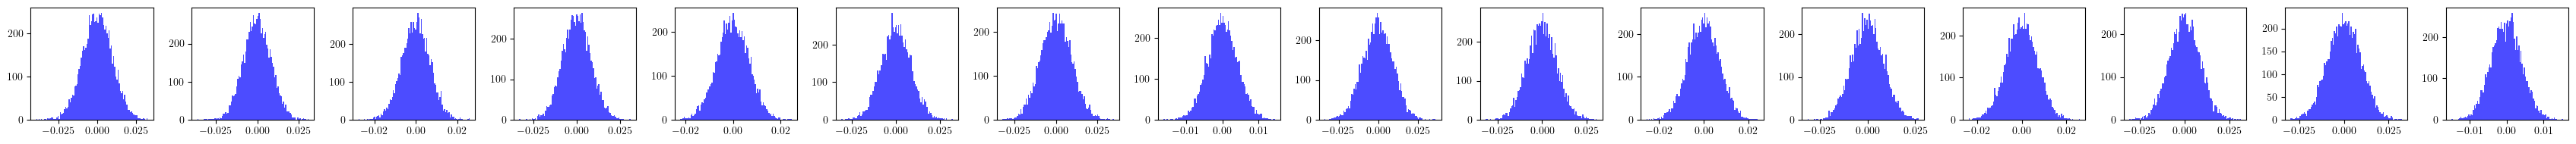

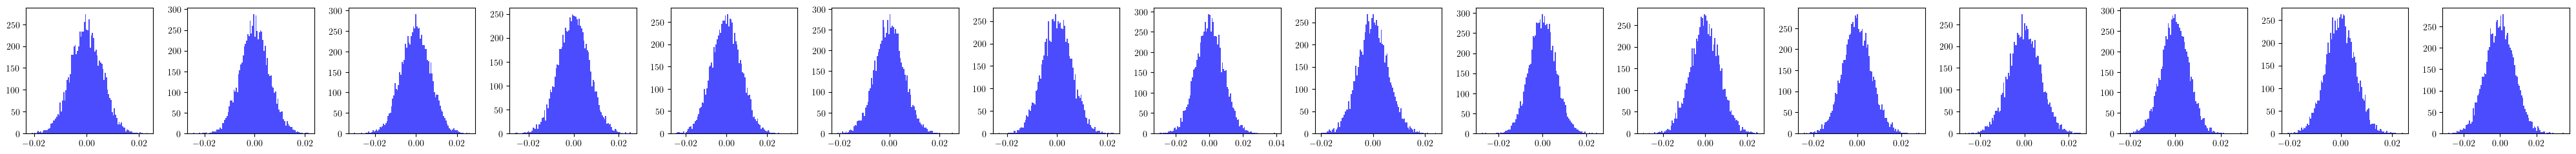

In [8]:
# Plot histograms

fig, axs = plt.subplots(1, len(ring), figsize=(17*2, 2))
for dmuqx, ax in zip(dmuqxs, axs):
    ax.hist(dmuqx.cpu().numpy(), bins=100, color='blue', alpha=0.7)
plt.tight_layout() 
plt.show()    

fig, axs = plt.subplots(1, len(ring), figsize=(len(ring)*2.5, 2.5))
for dmuqy, ax in zip(dmuqys, axs):
    ax.hist(dmuqy.cpu().numpy(), bins=100, color='blue', alpha=0.7)    
plt.tight_layout() 
plt.show()

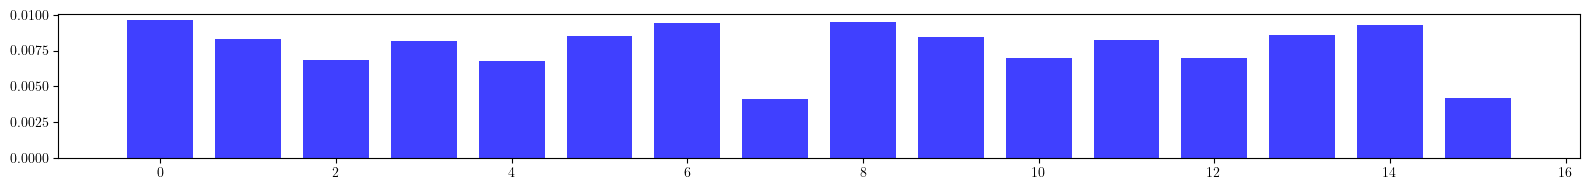

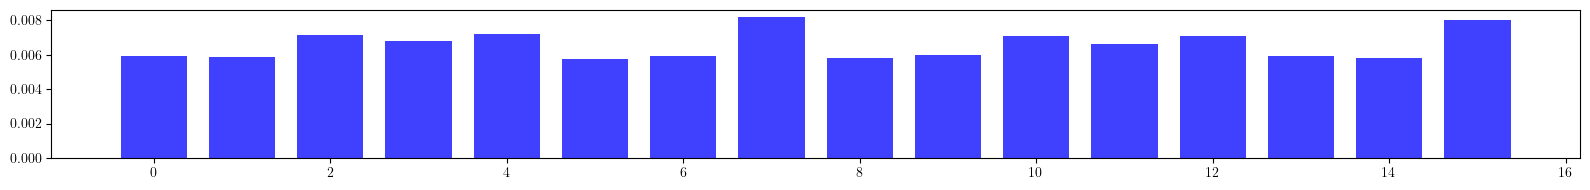

In [9]:
# Compute and plot spreads

sigma_dmuqxs = dmuqxs.std(1)
sigma_dmuqys = dmuqys.std(1)

plt.figure(figsize=(16, 2))
plt.bar(range(len(sigma_dmuqxs)), sigma_dmuqxs.cpu().numpy(), color='blue', alpha=0.75, width=0.75)
plt.tight_layout()
plt.show()

plt.figure(figsize=(16, 2))
plt.bar(range(len(sigma_dmuqys)), sigma_dmuqys.cpu().numpy(), color='blue', alpha=0.75, width=0.75)
plt.tight_layout()
plt.show()

torch.Size([16, 28])
torch.Size([16, 28])


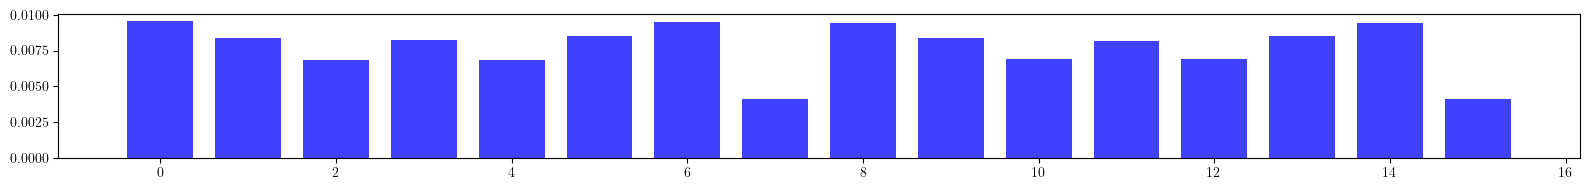

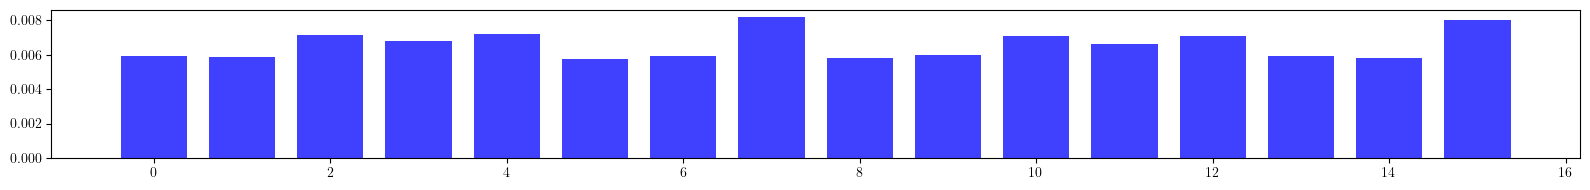

In [10]:
# Compute twiss derivatives and estimate spread from linear surrogate model using MC

# Compute derivatives

kn = torch.zeros(nq, dtype=torch.float64)
dmuqx_dk, dmuqy_dk = torch.func.jacrev(lambda kn: advance(ring, [kn], ('kn', ['Quadrupole'], None, None), matched=True, limit=1, epsilon=None), chunk_size=1024)(kn).swapaxes(0, 1)

print(dmuqx_dk.shape)
print(dmuqy_dk.shape)

# Sample

kns = 0.01*torch.randn((8192, nq), dtype=torch.float64)

dmuqxs = dmuqx_dk @ kns.T
dmuqxy = dmuqy_dk @ kns.T

# Compute and plot spreads

sigma_dmuqxs = dmuqxs.std(1)
sigma_dmuqys = dmuqys.std(1)

plt.figure(figsize=(16, 2))
plt.bar(range(len(sigma_dmuqxs)), sigma_dmuqxs.cpu().numpy(), color='blue', alpha=0.75, width=0.75)
plt.tight_layout()
plt.show()

plt.figure(figsize=(16, 2))
plt.bar(range(len(sigma_dmuqys)), sigma_dmuqys.cpu().numpy(), color='blue', alpha=0.75, width=0.75)
plt.tight_layout()
plt.show()

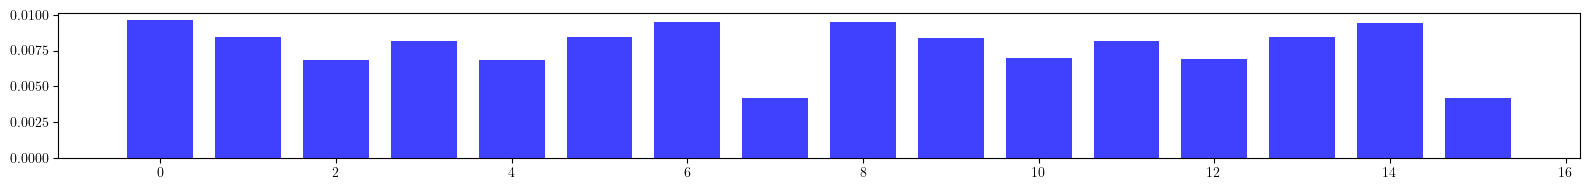

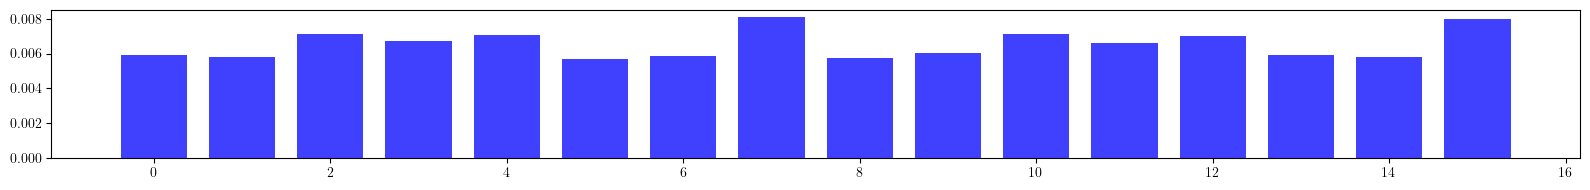

In [11]:
# Compute spread using error propagation

sigma_dmuqxs = (dmuqx_dk @ (0.01*torch.eye(nq,  dtype=torch.float64))**2 @ dmuqx_dk.T).diag().sqrt()
sigma_dmuqys = (dmuqy_dk @ (0.01*torch.eye(nq,  dtype=torch.float64))**2 @ dmuqy_dk.T).diag().sqrt()

plt.figure(figsize=(16, 2))
plt.bar(range(len(sigma_dmuqxs)), sigma_dmuqxs.cpu().numpy(), color='blue', alpha=0.75, width=0.75)
plt.tight_layout()
plt.show()

plt.figure(figsize=(16, 2))
plt.bar(range(len(sigma_dmuqys)), sigma_dmuqys.cpu().numpy(), color='blue', alpha=0.75, width=0.75)
plt.tight_layout()
plt.show()